### 📦 Dataset Attribution

This project uses the **FUTURA Synthetic Invoices Dataset**, publicly available via Zenodo:

> **FUTURA - Synthetic Invoices Dataset for Document Analysis**  
> Authors: Dimosthenis Karatzas, Fei Chen, Davide Fichera, Diego Marchetti  
> License: [Creative Commons Attribution 4.0 International (CC BY 4.0)](https://creativecommons.org/licenses/by/4.0/)  
> DOI: [https://doi.org/10.5281/zenodo.10371464](https://doi.org/10.5281/zenodo.10371464)  
> Accessed via Zenodo. Redistribution and derivative works must credit the original authors.

We gratefully acknowledge the authors for creating and releasing this dataset.

# 🧾 EDA on Invoice Fraud Detection Dataset (Updated)

In this notebook, we explore the updated dataset containing:
- 10,000 real invoice images
- 600 synthetically tampered invoice images

We’ll inspect image sizes, formats, and visualize random samples. We’ll also check the class imbalance and prepare insights for model training.

In [13]:
import os
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter

REAL_DIR = "../data/real"
TAMPERED_DIR = "../data/tampered"


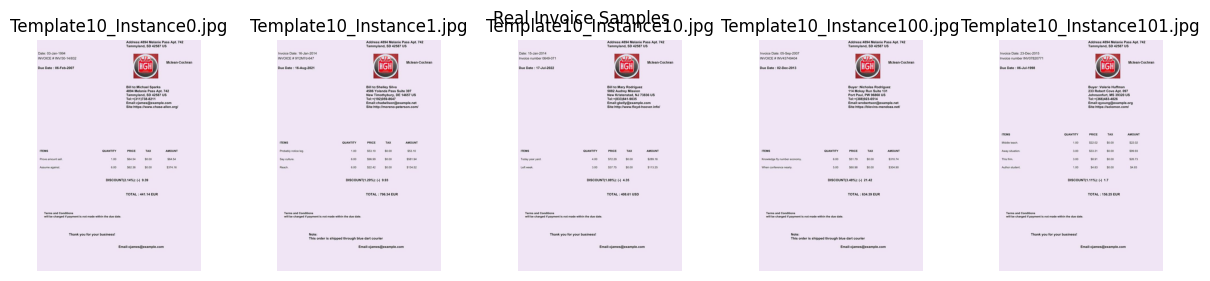

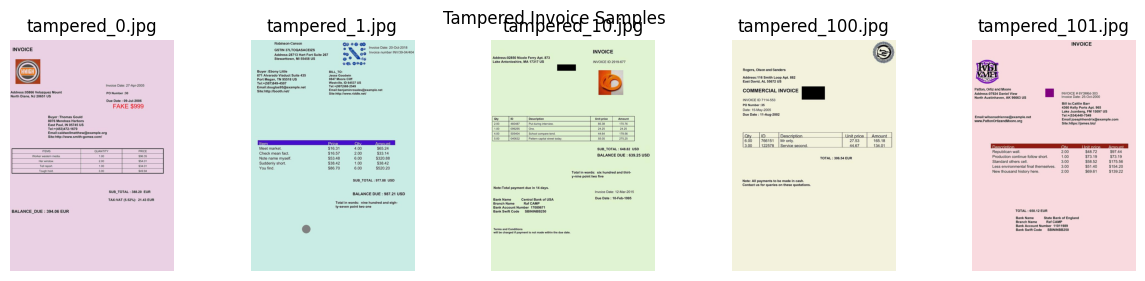

In [14]:
# 🖼️ Preview a few real and tampered images to visually inspect the dataset
def show_samples(folder, title, n=5):
    imgs = os.listdir(folder)[:n]
    plt.figure(figsize=(15, 3))
    for i, fname in enumerate(imgs):
        img = Image.open(os.path.join(folder, fname))
        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(fname)
    plt.suptitle(title)
    plt.show()

show_samples(REAL_DIR, "Real Invoice Samples")
show_samples(TAMPERED_DIR, "Tampered Invoice Samples")


In [15]:
# 🔍 Analyze image dimensions and color channels
def analyze_image_stats(folder):
    dims = Counter()
    modes = Counter()
    for fname in os.listdir(folder):
        img = Image.open(os.path.join(folder, fname))
        dims[img.size] += 1
        modes[img.mode] += 1
    print(f"\n📂 Folder: {folder}")
    print(f"Most common image sizes: {dims.most_common(3)}")
    print(f"Color modes distribution: {modes.most_common()}")

analyze_image_stats(REAL_DIR)
analyze_image_stats(TAMPERED_DIR)



📂 Folder: ../data/real
Most common image sizes: [((595, 841), 10000)]
Color modes distribution: [('RGB', 10000)]

📂 Folder: ../data/tampered
Most common image sizes: [((595, 841), 600)]
Color modes distribution: [('RGB', 600)]


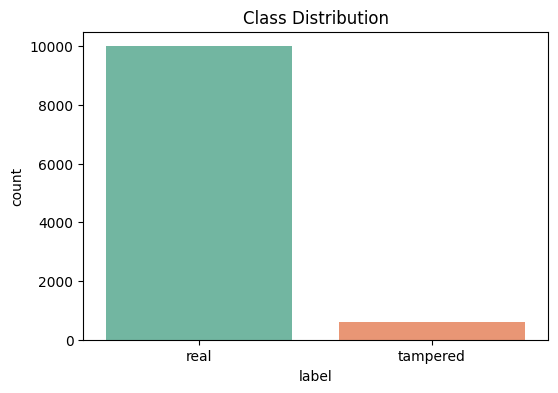

In [17]:
# 📊 Visualize class distribution
import seaborn as sns
import pandas as pd

labels = ['real'] * len(os.listdir(REAL_DIR)) + ['tampered'] * len(os.listdir(TAMPERED_DIR))
df = pd.DataFrame({'label': labels})
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=df, hue='label', palette='Set2', legend=False)
plt.title("Class Distribution")
plt.show()


In [19]:
# 🧼 Save processed data (images + labels) into /data/processed

import numpy as np
from tqdm import tqdm

PROCESSED_DIR = "../data/processed"
os.makedirs(PROCESSED_DIR, exist_ok=True)

def load_images_and_labels(real_dir, tampered_dir, target_size=(595, 841)):
    X, y = [], []

    print("🔹 Loading real images...")
    for fname in tqdm(os.listdir(real_dir)):
        path = os.path.join(real_dir, fname)
        img = Image.open(path).convert("RGB").resize(target_size)
        X.append(np.array(img))
        y.append(0)

    print("🔸 Loading tampered images...")
    for fname in tqdm(os.listdir(tampered_dir)):
        path = os.path.join(tampered_dir, fname)
        img = Image.open(path).convert("RGB").resize(target_size)
        X.append(np.array(img))
        y.append(1)

    return np.array(X), np.array(y)

# Load and save
X, y = load_images_and_labels(REAL_DIR, TAMPERED_DIR)

np.save(os.path.join(PROCESSED_DIR, "X.npy"), X)
np.save(os.path.join(PROCESSED_DIR, "y.npy"), y)

print(f"✅ Saved {len(X)} images and labels to {PROCESSED_DIR}")

🔹 Loading real images...


  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [01:45<00:00, 94.61it/s]


🔸 Loading tampered images...


100%|██████████| 600/600 [00:06<00:00, 97.73it/s] 


✅ Saved 10600 images and labels to ../data/processed


In [20]:
# ✅ Verify the shape and type of the saved arrays
import numpy as np

X = np.load('../data/processed/X.npy')
y = np.load('../data/processed/y.npy')

print(f"🧪 X shape: {X.shape} | dtype: {X.dtype}")
print(f"🧪 y shape: {y.shape} | dtype: {y.dtype}")
print(f"🔢 Unique labels: {np.unique(y, return_counts=True)}")


🧪 X shape: (10600, 841, 595, 3) | dtype: uint8
🧪 y shape: (10600,) | dtype: int64
🔢 Unique labels: (array([0, 1]), array([10000,   600]))


# 📊 Exploratory Data Analysis (EDA) Summary

In this notebook, we conducted a comprehensive exploratory data analysis to understand the structure and distribution of our invoice image dataset.

## 🔍 Key Steps Completed

1. **Loaded the real and tampered invoice images** from the dataset folders (`data/real` and `data/tampered`).
2. **Visualized a few sample images** from both classes to inspect visual differences between authentic and fake invoices.
3. **Analyzed metadata** such as image resolution and color mode, confirming that:
   - All images are `.jpg`
   - They share the same size: `595 x 841` pixels
   - All are in `RGB` color format
4. **Counted class distributions**:
   - `Real` invoices: 10,000
   - `Tampered` invoices: 600  
   This reveals a clear class imbalance (~16:1 ratio).
5. **Normalized and resized images**, saving them into `data/processed/` as:
   - `X.npy`: Preprocessed image tensors
   - `y.npy`: Corresponding labels (`0` = real, `1` = tampered)

---

## ⚖️ Why We Are Moving Forward With Imbalanced Classes

Although the dataset has far fewer tampered samples, we decided **not to generate 10,000 fake samples** because:

1. **Synthetic tampering gets repetitive** beyond a point and can lead to overfitting.
2. **Realistic tampering diversity is limited**, and forcing high numbers risks making models memorize artificial patterns.
3. **We will handle the imbalance during model training** using:
   - `class_weight` in the loss function
   - `data augmentation` to simulate diverse samples
   - `evaluation metrics` like F1-score, precision, and recall, which are better suited for imbalanced classification.

---

## 🛠️ Next Steps: Train the CNN Model

Now that the dataset is processed and ready, we will move on to `02_train_model.ipynb`, where we will:
- Define and compile a CNN architecture
- Apply augmentation to improve generalization
- Train the model using class weighting
- Evaluate its performance

---